In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math
import numpy as np
import math
import numpy
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import multiprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import models, Model
import numpy as np

class DataSet():
    def __init__(self, num_words=None, seed=113, maxlen=100, train_portion=0.5, long_first=False):
        """
        :param num_words: Size of vocabulary, all words out-of-vocabulary will be marked as [unk]
        :param seed: Seed for randomly shuffling dataset
        :param maxlen: Maximum length of review, reviews longer than maxlen will be truncated, reviews shorter than
        maxlen will be padded to maxlen
        :param train_portion: Portion of dataset to allocate to training data, test data will be 1-train_portion
        :param long_first: Sort reviews by length
        """
        # retrieve IMDb data, x is a sequence containing movie review,
        # y is a label indicating if it is positive or negative sentiment
        (self.x_train, self.y_train), (self.x_test, self.y_test) = imdb.load_data(num_words=num_words, seed=seed)

        if long_first:
            self.y_train = [y for _, y in sorted(zip(self.x_train, self.y_train), key=lambda s: len(s[0]), reverse=True)]
            self.x_train = sorted(self.x_train, key=len, reverse=True)

            self.y_test = [y for _, y in sorted(zip(self.x_test, self.y_test), key=lambda s: len(s[0]), reverse=True)]
            self.x_test = sorted(self.x_test, key=len, reverse=True)

        self.total_length = [len(x) for x in self.x_train]
        temp = [len(x) for x in self.x_test]
        self.total_length.extend(temp)

        # padding sequences to all be of the same length
        self.x_train = pad_sequences(self.x_train, maxlen=maxlen, padding='post', truncating='post')
        self.x_test = pad_sequences(self.x_test, maxlen=maxlen, padding='post', truncating='post')

        self.split_data(train_portion)

        self.word_index = imdb.get_word_index()
        self.word_to_index = {word:id + 3 for word, id in self.word_index.items()}
        self.word_to_index["[pad]"] = 0
        self.word_to_index["[start]"] = 1
        self.word_to_index["[unk]"] = 2
        self.word_to_index["[unused]"] = 3
        self.index_to_word = {i:word for (word, i) in self.word_to_index.items()}
        self.form_vocab()

    def form_vocab(self):
        i2w_vocab = {}
        w2i_vocab = {}

        for sentence in self.x_train:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id

        for sentence in self.x_test:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id
        self.i2w_vocab = i2w_vocab
        self.w2i_vocab = w2i_vocab

    def get_data(self):
        return (self.x_train, self.y_train), (self.x_test, self.y_test), (self.train_length, self.test_length)

    def get_vocab_length(self):
        return len(self.i2w_vocab)

    # splits data into ratio train:test -> (train_portion:1-train_portion)
    def split_data(self, train_portion):
        x = np.concatenate((self.x_train, self.x_test), axis=0)
        y = np.concatenate((self.y_train, self.y_test), axis=0)
        self.train_length, self.test_length = self.total_length[:math.floor(train_portion * len(x))], \
                                              self.total_length[math.floor(train_portion * len(x)):]
        self.x_train, self.x_test = x[:math.floor(train_portion * len(x))], \
                                    x[math.floor(train_portion * len(x)):]
        self.y_train, self.y_test = y[:math.floor(train_portion * len(y))], \
                                    y[math.floor(train_portion * len(y)):]
        return None

2023-10-12 02:50:07.677487: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(array([6797780.,  238797.,  133359.,   88225.,   63689.,   51162.,
          40494.,   34180.,   27794.,   24520.]),
 array([   0. ,  399.9,  799.8, 1199.7, 1599.6, 1999.5, 2399.4, 2799.3,
        3199.2, 3599.1, 3999. ]),
 <BarContainer object of 10 artists>)

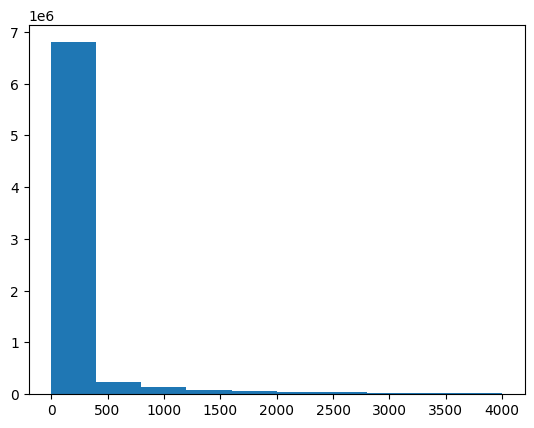

In [129]:
dataset = DataSet(4000, maxlen=500, train_portion=0.7)
with open('dataset_4000_70.pkl', 'wb') as f:
    pickle.dump(dataset, f)
(x_train, y_train), (x_test, y_test),(_,_) = dataset.get_data()

In [ ]:
# import math
import numpy
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import multiprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import models, Model
import numpy as np
from numba import guvectorize,cuda,jit

def get_mean_vector(h_set):
    """
    :param h_set: list of vectors h, each vector is output of LSTM layer at a timestep
    :return: mean vector hbar
    """
    hbar = h_set[0]
    for i in range(1, len(h_set)):
        hbar += h_set[i]
    hbar = hbar / len(h_set)
    return hbar

def get_magnitude(vector):
    """
    :param vector: 1D numpy array
    :return: magnitude of vector
    """
    magnitude = 0
    for element in vector:
        magnitude += element ** 2
    return math.sqrt(magnitude)

def get_norm(vector):
    return vector / get_magnitude(vector)

def project(vector, basis):
    """
    :param vector: vector to project onto basis
    :param basis: basis for poincare map
    :return: vector projected onto basis (dot product)
    """
    return vector.dot(basis)


def get_poincare_mapping(lstm, start, num_steps, intermediate_inputs=None):
    if intermediate_inputs is None:
        intermediate_inputs = [np.zeros(len(start), dtype=np.float64) for _ in range(num_steps - 1)]


    h_t = [lstm.step(start)[-1]]
    h_t_1 = [] # h_{t+1}
    for i in range(num_steps - 1):
        curr_h = lstm.step(intermediate_inputs[i])[-1]
        h_t.append(curr_h)
        h_t_1.append(curr_h)
    h_t.pop() # remove last element so h_t and h_{t+1} aligns
    return h_t, h_t_1



def main(n):       
    # numbers setup
    class LSTM_layer():
        @staticmethod
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        @staticmethod
        def tanh(x): # for consistency
            return np.tanh(x)

        def __init__(self, weights):
            """
            :param weights: weights of LSTM layer
            """
            # transposing matrices for dot product
            self.W, self.U, self.b = np.transpose(weights[0]), np.transpose(weights[1]), np.transpose(weights[2])
            self.num_units = int(self.U.shape[1])
            self.split_weights()
            # LSTM trained stateless, initial C and h are zero vectors
            self.C = np.zeros((self.num_units), dtype=np.float64)
            self.h = np.zeros((self.num_units), dtype=np.float64)

        def split_weights(self):
            # weights are stored as (neuron_num, (i, f, c, o))
            self.W_i = np.ascontiguousarray(self.W[:self.num_units, :])
            self.W_f = np.ascontiguousarray(self.W[self.num_units:self.num_units * 2, :])
            self.W_c = np.ascontiguousarray(self.W[self.num_units * 2:self.num_units * 3, :])
            self.W_o = np.ascontiguousarray(self.W[self.num_units * 3:, :])

            self.U_i = np.ascontiguousarray(self.U[:self.num_units, :])
            self.U_f = np.ascontiguousarray(self.U[self.num_units:self.num_units * 2, :])
            self.U_c = np.ascontiguousarray(self.U[self.num_units * 2:self.num_units * 3, :])
            self.U_o = np.ascontiguousarray(self.U[self.num_units * 3:, :])

            self.b_i = np.ascontiguousarray(self.b[:self.num_units])
            self.b_f = np.ascontiguousarray(self.b[self.num_units:self.num_units * 2])
            self.b_c = np.ascontiguousarray(self.b[self.num_units * 2:self.num_units * 3])
            self.b_o = np.ascontiguousarray(self.b[self.num_units * 3:])

        def step(self, x_t):
            """
            Performs a timestep (propagating new input through layer)
            :return: array of activations [ft, it, cc, cc_update, c_out, ot, ht]
            """
            activations = []
            # forget step
            ft = self.get_ft(x_t)
            activations.append(ft)
            self.forget(ft)

            # "remembering" step
            it = self.get_it(x_t)
            activations.append(it)
            cc = self.get_CC(x_t)
            activations.append(cc)
            cc_update = self.get_CC_update(it, cc)
            activations.append(cc_update)
            self.remember(cc_update)

            # output step
            c_out = self.get_C_output()
            activations.append(c_out)
            ot = self.get_ot(x_t)
            activations.append(ot)
            output = self.output(c_out, ot)
            activations.append(output)

            return activations

        def reset(self):
            # call when done with one input (with all timesteps completed)
            # resets internal cell state and starting hidden state
            self.C = np.zeros((self.num_units), dtype=np.float64)
            self.h = np.zeros((self.num_units), dtype=np.float64)


        # vectorized activation propagation
        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)" 
        )
        def get_ft_vec(W_f, U_f, x_t, h, b_f, res):
            wfx = W_f.dot(x_t)
            ufh = U_f.dot(h)
            sum_int = wfx + ufh
            sum_f = sum_int + b_f
            res[:] = 1 / (1 + np.exp(-sum_f))
        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)"
    
        )
        def get_it_vec(W_i, U_i, x_t, h, b_i, res):
            wix = W_i.dot(x_t)
            uih = U_i.dot(h)
            sum_int = wix + uih
            sum_f = sum_int + b_i
            res[:] = 1 / (1 + np.exp(-sum_f))

        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)"
     
        )
        def get_CC_vec(W_c, U_c, x_t, h, b_c, res):
            wcx = W_c.dot(x_t)
            uch = U_c.dot(h)
            sum_int = wcx + uch
            sum_f = sum_int + b_c
            res[:] = np.tanh(sum_f)

        @staticmethod
        @guvectorize(
            ["float64[:, :], float64[:, :], float64[:], float64[:], float64[:], float64[:]"],
            "(n, m),(n, n),(m),(n),(n)->(n)"
   
        )
        def get_ot_vec(W_o, U_o, x_t, h, b_o, res):
            wox = W_o.dot(x_t)
            uoh = U_o.dot(h)
            sum_int = wox + uoh
            sum_f = sum_int + b_o
            res[:] = 1 / (1 + np.exp(-sum_f))

        # activations start
        # tanh activations don't see an improvement from vectorization (probably because tanh is already vectorized)
        def get_ft(self, x_t):
            # sigmoid(W_f . x_t + U_f . h_(t-1) + b_f) . is dot product
            # wfx = self.W_f.dot(x_t)
            # ufh = self.U_f.dot(self.h)
            # return LSTM_layer.sigmoid(wfx + ufh + self.b_f)
            return LSTM_layer.get_ft_vec(self.W_f, self.U_f, x_t, self.h, self.b_f)

        def get_it(self, x_t):
            # sigmoid(W_i . x_t + U_i . h_(t-1) + b_i)
            # wix = self.W_i.dot(x_t)
            # uih = self.U_i.dot(self.h)
            # return LSTM_layer.sigmoid(wix + uih + self.b_i)
            return LSTM_layer.get_it_vec(self.W_i, self.U_i, x_t, self.h, self.b_i)

        def get_CC(self, x_t):
            # candidate cell state before proportion
            # tanh(W_c . x_t + U_c . h_(t-1) + b_c)
            wcx = self.W_c.dot(x_t)
            uch = self.U_c.dot(self.h)
            return LSTM_layer.tanh(wcx + uch + self.b_c)
            # return LSTM_layer.get_CC_vec(self.W_c, self.U_c, x_t, self.h, self.b_c)

        def get_ot(self, x_t):
            # sigmoid(W_o . x_t + U_o . h_(t-1) + b_o)
            # wox = self.W_o.dot(x_t)
            # uoh = self.U_o.dot(self.h)
            # return LSTM_layer.sigmoid(wox + uoh + self.b_o)
            return LSTM_layer.get_ot_vec(self.W_o, self.U_o, x_t, self.h, self.b_o)

        def get_C_output(self):
            # cell state output before proportion
            # tanh(C_t)
            return LSTM_layer.tanh(self.C)

        def get_CC_update(self, it, cc):
            # candidate cell state after proportion, for updating cell state
            # it * cc, * is Hadamard product
            return it * cc
        # activations end


        # state updates start
        def forget(self, ft):
            # update old cell state in the forget step
            self.C = self.C * ft

        def remember(self, cc_update):
            # update old cell state with new information
            self.C = self.C + cc_update

        def output(self, c_output, ot):
            # proportionate the cell output vector for new output and hidden state
            self.h = c_output * ot
            return self.h


    
    # state updates end
    num_timesteps = 500
    len_sequence = 1000
    num_cells = 60
    av=[]
    with open('LSTM/dataset_4000_70.pkl', 'rb') as f:
        dataset = pickle.load(f)
  
    #i=950
    _, x, length = dataset.get_data()
    _, length = length
    x, y = x

    if n<10:
        filepath='LSTM/weights.0'+str(n)+'.hdf5'
    else:
        filepath='LSTM/weights.'+str(n)+'.hdf5'
    model= models.load_model(filepath,compile=False)
    embed_layer = Model(inputs=model.input, outputs=model.layers[1-1].output)
    lm=[]
    for i in range(118,1181,20):
        #x_in=np.zeros((1,500),int).tolist()
        # print(length[i])
        # if length[i] < 350:
        #     continue
        #x_in_gau = x[i].reshape((1, num_timesteps))+ random.gauss(0,1e-15)
        #x_in_gau = x_in + random.gauss(0,0.0001)
        #print(x_in[0])
        #print(x_in_gau)
        x_in = x[i].reshape((1,num_timesteps))
        #x_in=np.zeros((1,500),int).tolist()
        # print(length[i])
        # if length[i] < 350:
        #     continue
        #x_in_gau = x[i].reshape((1, num_timesteps))+ random.gauss(0,1e-15)
        #x_in_gau = x_in + random.gauss(0,0.0001)
        #print(x_in[0])
        #print(x_in_gau)
        lstm_in = embed_layer.predict(x_in)[0]
        lstm_in=np.float64(lstm_in)
        lstm_in_gau=embed_layer.predict(x_in)[0]
        a=model.layers[1].get_weights()
        for e in range(len(a)):
                a[e]=np.float64(a[e])
        c=model.layers[1].get_weights()
        for e in range(len(c)):
                c[e]=np.float64(c[e])
        lstm = LSTM_layer(a)
        lstm_gau = LSTM_layer(c)
        start = lstm_in[1-1]
        random.seed(42)
        start_gau=lstm_in_gau[1-1]+random.gauss(0,0.05)
                #print(np.array(start).shape)
                    #inte rmediate_steps = np.zeros((75000,32))
        xt=np.zeros((75000,32))
        intermediate_steps = lstm_in[1:].tolist()+xt.tolist()
        intermediate_steps_gau= lstm_in[1:].tolist()+xt.tolist()
                #print(intermediate_steps)
        h_t_late, h_t_1_late = get_poincare_mapping(lstm, start,len_sequence,intermediate_steps)
        h_t_late.append(h_t_1_late[-1])
        hbar_late = get_mean_vector(h_t_late)
        h_t_late_gau, h_t_1_late_gau = get_poincare_mapping(lstm_gau, start_gau,len_sequence,intermediate_steps)
                #print(h_t_late_gau[
        h_t_late_gau.append(h_t_1_late_gau[-1])
        late_set=[]
                    #print(len(h_t_late_gau))
                #print(len(h_t_late))
        for j in range(len(h_t_late)-3, len(h_t_late)):

                        vec1=np.array(h_t_late[j])

                        vec2=np.array(h_t_late_gau[j])
                        dist = numpy.linalg.norm(vec1 - vec2)

                        dist_late=numpy.log(dist+numpy.exp(-25))

                        late_set.append(dist_late)

        lm.append(np.mean(late_set))
        print(np.mean(late_set))
    return lm
            
    
if __name__ == "__main__":
    #pool=multiprocessing.Pool(processes=8)
    #for i in range(233,420):
        #pool.apply_async(main, (i, ))
        x=[]
        for i in range(1,1201):
            x.append(main(i))


/tmp/ipykernel_140/1119785315.py:155: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  wfx = W_f.dot(x_t)
2023-10-12 02:50:46.355971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31114 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0
2023-10-12 02:50:47.262311: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-12 02:50:47.264450: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error a

1/1 [==============================] - 0s 20ms/step
-24.999999581454347
1/1 [==============================] - 0s 20ms/step
-24.9999993585585
1/1 [==============================] - 0s 20ms/step
-24.99999956960312
1/1 [==============================] - 0s 20ms/step
-24.999999680865937
1/1 [==============================] - 0s 20ms/step
-24.99999959902429
1/1 [==============================] - 0s 19ms/step
-24.99999965707301
1/1 [==============================] - 0s 20ms/step
-24.999999651210285
1/1 [==============================] - 0s 20ms/step
-24.999999755349837
1/1 [==============================] - 0s 20ms/step
-24.999999621331515
1/1 [==============================] - 0s 20ms/step
-24.999999787489017
1/1 [==============================] - 0s 20ms/step
-24.999999695135276
1/1 [==============================] - 0s 20ms/step
-24.999999517689037
1/1 [==============================] - 0s 20ms/step
-24.9999997853687
1/1 [==============================] - 0s 20ms/step
-24.99999952183735


2023-10-12 02:51:36.972029: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-12 02:51:36.974283: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-12 02:51:36.975951: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

-24.999999700784247
1/1 [==============================] - 0s 20ms/step
-24.999999674964812
1/1 [==============================] - 0s 20ms/step
-24.999999612759073
1/1 [==============================] - 0s 20ms/step
-25.0
1/1 [==============================] - 0s 20ms/step
-24.999999271142755
1/1 [==============================] - 0s 20ms/step
-24.99999970170224
1/1 [==============================] - 0s 20ms/step
-24.99999998438643
1/1 [==============================] - 0s 20ms/step
-24.999999905026343
1/1 [==============================] - 0s 20ms/step
-24.999999491466497
1/1 [==============================] - 0s 19ms/step
-24.99999963549752
1/1 [==============================] - 0s 24ms/step
-24.999999651645066
1/1 [==============================] - 0s 19ms/step
-24.99999986034796
1/1 [==============================] - 0s 20ms/step
-24.99999998438643
1/1 [==============================] - 0s 20ms/step
-24.999999516506914
1/1 [==============================] - 0s 20ms/step
-24.9999996

In [668]:
xx=[(x[1-1][i],a[i])for i in range(len(a))]
xx

[(-7.646951984684754, 1.293286455705811e-08),
 (-7.230691094775598, 7.65509167166556e-09),
 (-9.322496437210441, 1.2036093233191991e-09),
 (-10.549286340145846, 2.0680487011759396e-07),
 (-6.494407121509192, 10.867687225341797),
 (-8.041937611502975, 1.8072314755812613e-09),
 (-9.392672021969432, 1.1790412912660031e-07),
 (-9.415186318863912, 3.17508286329371e-09),
 (-11.017331270380856, 2.4501218795776367),
 (-10.132099159505275, 2.3140833036450204e-06),
 (-6.803404829524372, 4.341123104095459),
 (-12.895567026102512, 4.846157253268757e-07),
 (-7.755579686335545, 3.3488956319160934e-07),
 (-7.433173087233875, 14.435453414916992),
 (-9.897882809415497, 1.7272835384218865e-09),
 (-9.401764607288811, 13.961176872253418),
 (-5.828507404987664, 6.661260840701289e-07),
 (-8.051575570016878, 4.381387710571289),
 (-8.806934354826433, 3.0169196918450325e-08),
 (-9.81417823720266, 1.603382870918324e-09),
 (-8.115805730007576, 3.3303277291452105e-07),
 (-8.77788371917953, 8.52678340379498e-07),


In [664]:
x,a

([[-7.646951984684754,
   -7.230691094775598,
   -9.322496437210441,
   -10.549286340145846,
   -6.494407121509192,
   -8.041937611502975,
   -9.392672021969432,
   -9.415186318863912,
   -11.017331270380856,
   -10.132099159505275,
   -6.803404829524372,
   -12.895567026102512,
   -7.755579686335545,
   -7.433173087233875,
   -9.897882809415497,
   -9.401764607288811,
   -5.828507404987664,
   -8.051575570016878,
   -8.806934354826433,
   -9.81417823720266,
   -8.115805730007576,
   -8.77788371917953,
   -10.142898750542665,
   -8.857807738152736,
   -9.098375809013909,
   -8.172556189167361,
   -8.475358417195112,
   -7.2592075306152894,
   -6.042407545365347,
   -9.9765304900467,
   -8.784534573222757,
   -8.707700072306135,
   -8.998231682230626,
   -10.739599430675087,
   -9.562364704785553,
   -8.148482878695537,
   -8.945956835980324,
   -12.605325721115944,
   -12.860610728359609,
   -7.6251631267115085,
   -10.540963759282613,
   -6.260025564424036,
   -10.048549422226149,
   

In [582]:
with open('ml4.pkl', 'rb') as f:
        x=pickle.load(f)

846

In [570]:
distribi=[]
for n in range(1,1001):
    if n<10:
            filepath='paper(2 and3)/paper2/'+'weights.0'+str(n)+'.hdf5' 
    else:
            filepath= 'paper(2 and3)/paper2/'+'weights.'+str(n)+'.hdf5'  

    model= models.load_model(filepath,compile=False)
    weights=[model.layers[1].get_weights()[i].flatten().tolist() for i in range(3-1)]
    w=[]
    for i in weights:
        w+=i
    weights=w
    distribi.append(np.var(weights))
plt.plot(distribi)

2023-10-11 12:48:59.532646: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 12:48:59.534890: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 12:48:59.536987: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
num_timesteps = 500
len_sequence = 1000
num_cells = 60
av=[]
with open('paper(2 and3)/paper2/dataset_4000_70.pkl', 'rb') as f:
        dataset = pickle.load(f)
losses = []  
    #i=950
(x_train, y_train), (x_test, y_test),(_,_) = dataset.get_data()
for n in range(1,1101):
    if n<10:
        filepath='paper(2 and3)/paper2/weights.0'+str(n)+'.hdf5'
    else:
        filepath='paper(2 and3)/paper2/weights.'+str(n)+'.hdf5'
    model= models.load_model(filepath)

    for i in range(118,1180,20):
        # Prepare a single test data point
        test_data_point = np.array([x_test[i]])
        test_label = np.array([y_test[i]])

        # Calculate the loss for the test data point
        loss,acc = model.evaluate(test_data_point, test_label, verbose=0)

        losses.append(loss)


2023-10-11 14:58:38.832817: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-11 14:58:38.835040: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-11 14:58:38.836719: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

[7.559030734682892e-08,
 3.9661653516986917e-08,
 4.017167398728816e-08,
 3.4086990581272403e-06,
 0.07500433921813965,
 2.205041660374718e-08,
 1.1615105904638767e-05,
 1.0078202450358731e-07,
 0.0019932882860302925,
 2.933834821305936e-06,
 0.0009522945038042963,
 9.148242838818987e-07,
 4.867288225796074e-06,
 11.675291061401367,
 1.0021616247968268e-07,
 11.638925552368164,
 1.4508591448247898e-05,
 0.016699818894267082,
 1.096272015388422e-07,
 3.9918475636113726e-08,
 3.2019966056395788e-06,
 0.3530495762825012,
 12.073600769042969,
 10.153685569763184,
 4.256863576301839e-06,
 3.097263459039823e-07,
 8.335004508808197e-08,
 7.376529993052827e-06,
 2.4838727767928503e-05,
 7.297608561884772e-08,
 6.46337284706533e-05,
 8.196308044716716e-05,
 2.595681962702656e-06,
 3.212317460565828e-05,
 1.1190708391950466e-05,
 8.424718771493644e-07,
 6.114901225373615e-06,
 2.4900657535908977e-06,
 0.0005772773292846978,
 8.693622532973677e-08,
 3.7644306303263875e-06,
 3.3098565666023205e-08

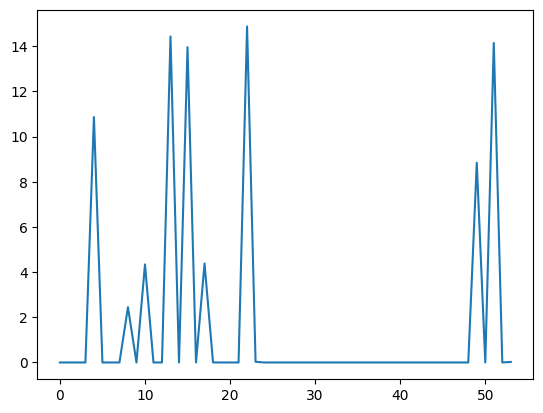

In [658]:
plt.plot(losses[54*897:54*898])
a=(losses[54*897:54*898])
